# UpscaleModel training
Below, we train the Upscale model, which takes the activations of the selected ResNet50 layer as input and attempts to reconstruct the image, which produced them.

In [13]:
%load_ext autoreload
%autoreload 2

import os
import torch

from os.path import join
from csng.imagenet.models import ResnetExtractor, UpsampleModel, count_parameters
from tqdm import tqdm
from random import random
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torchvision

from matplotlib import pyplot as plt
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Define the image limit
BATCH_SIZE = 64

TRAIN_SIZE = 500 * BATCH_SIZE
TEST_SIZE = 20 * BATCH_SIZE
LOSS_EVERY = 5
EPOCHS = 1
WEIGHT_DECAY=5e-3
LEARNING_RATE = .00005

device = os.environ["DEVICE"]

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

In [15]:
class CachedImageNet(ImageNet):
    """
    ImageNet dataset with caching for the features extracted from the ResNet model.
    """
    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet_extractor = None

    def get_extractor(self):
        if self.resnet_extractor is None:
            self.resnet_extractor = ResnetExtractor()
        return self.resnet_extractor

    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path):
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imagenet_input = torchvision.transforms.functional.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)
            features = self.get_extractor().get_features(imagenet_input)
            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)

mp.set_start_method('spawn', force=True)

train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split='train',
    version='1.1'
)
assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)


# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Train loader contains 500 batches.
Test loader contains 20 batches.


torch.Size([64, 1, 224, 224])


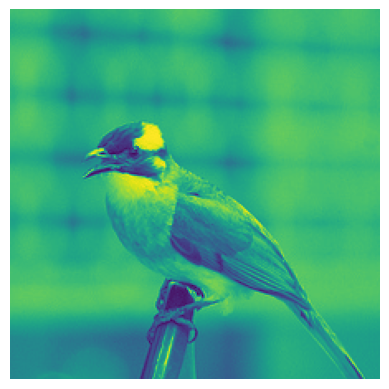

In [16]:
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])

In [17]:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print("Total parametrs: ", params)
print("Params in samples : ", params / (224*224))

Total parametrs:  24511329
Params in samples :  488.5070352359694


In [18]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [ ]:
# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in tqdm(enumerate(train_loader)):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


5it [00:21,  4.25s/it]

Epoch 1, Batch 5, LR: 0.000050, Loss: 0.7497


10it [00:42,  4.28s/it]

Epoch 1, Batch 10, LR: 0.000050, Loss: 0.6376


15it [01:03,  4.25s/it]

Epoch 1, Batch 15, LR: 0.000050, Loss: 0.6058


20it [01:24,  4.13s/it]

Epoch 1, Batch 20, LR: 0.000050, Loss: 0.6005


25it [01:45,  4.14s/it]

Epoch 1, Batch 25, LR: 0.000050, Loss: 0.5939


30it [02:06,  4.17s/it]

Epoch 1, Batch 30, LR: 0.000050, Loss: 0.5874


35it [02:27,  4.22s/it]

Epoch 1, Batch 35, LR: 0.000049, Loss: 0.5857


40it [02:48,  4.23s/it]

Epoch 1, Batch 40, LR: 0.000049, Loss: 0.5856


45it [03:09,  4.21s/it]

Epoch 1, Batch 45, LR: 0.000049, Loss: 0.5885


50it [03:30,  4.26s/it]

Epoch 1, Batch 50, LR: 0.000049, Loss: 0.5847


55it [03:51,  4.17s/it]

Epoch 1, Batch 55, LR: 0.000049, Loss: 0.5857


60it [04:12,  4.25s/it]

Epoch 1, Batch 60, LR: 0.000048, Loss: 0.5776


65it [04:34,  4.30s/it]

Epoch 1, Batch 65, LR: 0.000048, Loss: 0.5835


67it [04:43,  4.42s/it]

Text(0, 0.5, 'Loss')

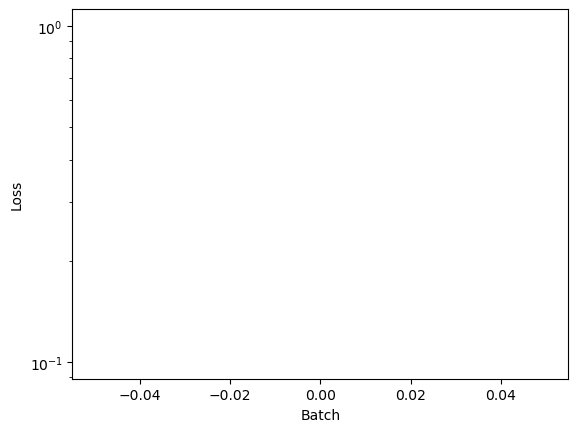

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Batch')
plt.ylabel('Loss')

# set maximum y to 

# Evaluating performance on the test set

  0%|                                                                                        | 0/20 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.96s/it]


Test Loss: 0.7398


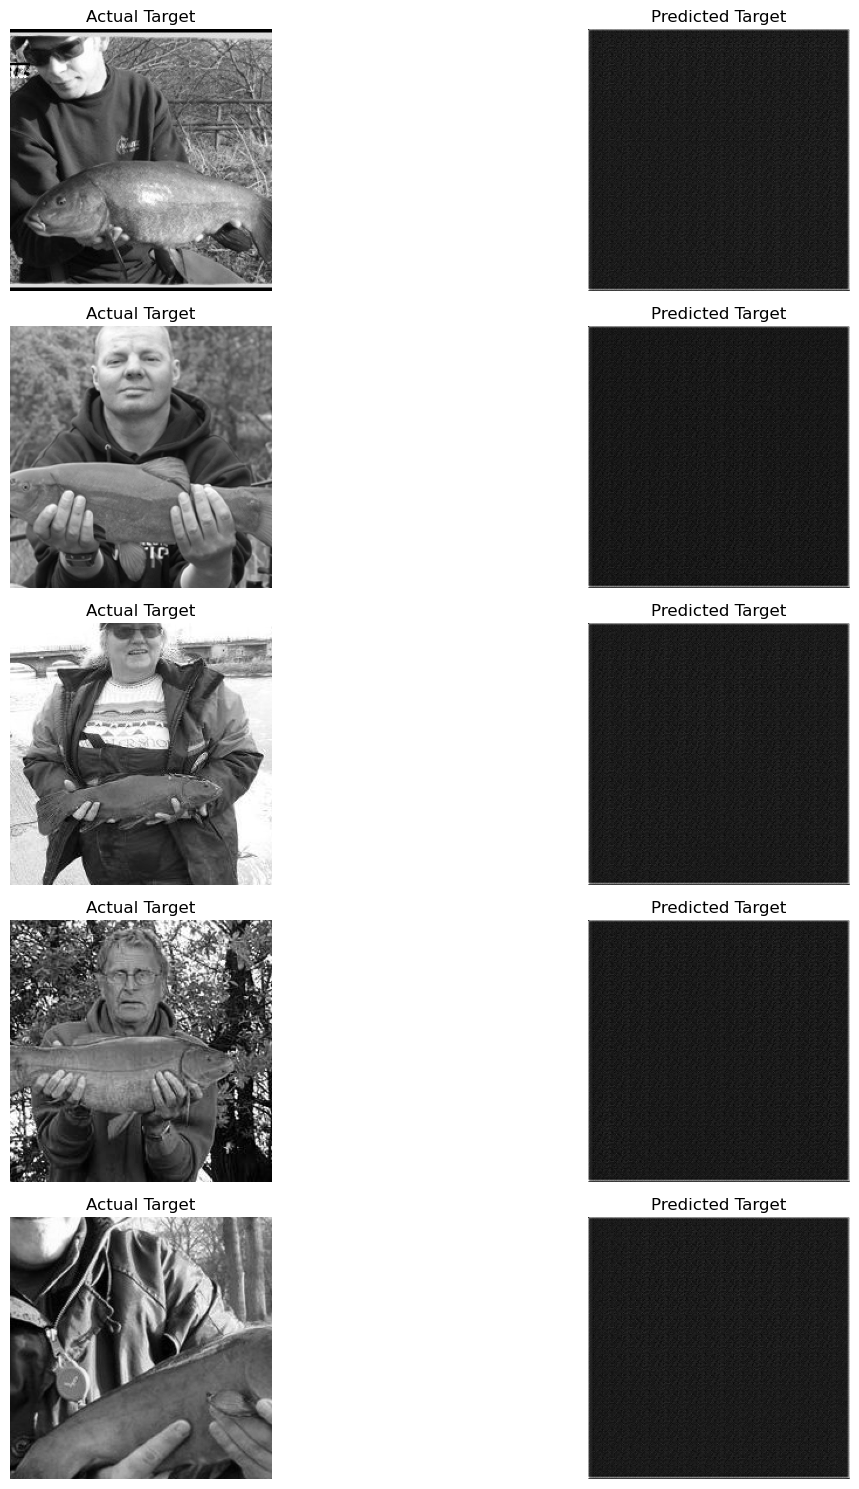

In [ ]:

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions


def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
name = join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt")
torch.save(model, name)
print("Model saved to ", name)

Model saved to  /scratch/izar/vanousek/cs-433-project/models/mlp2498275.pt


# Validation
The validation loss was only evaluated after the hyperparameters were tuned on the training set.

In [12]:

val_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split='val',
    version='1.1'
)

val_subset_indices = list(range(BATCH_SIZE * 100))  # Indices for the training subset

# Create the subsets
val_subset = Subset(val_dataset, train_subset_indices)

val_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Validation Loss: {test_loss_partial:.4f}")

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.19it/s]

Validation Loss: 0.7398
